In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
drive_cycle = pd.read_csv("current_data.csv")

In [3]:
drive_cycle.shape[0]

63519

In [4]:
new_time = np.arange(0, 63519)
drive_cycle['Testtime [s]'] = new_time
drive_cycle = drive_cycle.to_numpy()
time_data = drive_cycle[:, 0]  # 时间数据，单位为秒
current_data = drive_cycle[:, 1]  # 电流数据，单位为安培

In [5]:
time_data.shape[0]

63519

In [6]:
# 步骤 2：创建插值函数
# 使用 pybamm.Interpolant 创建插值函数
current_interpolant = pybamm.Interpolant(time_data, current_data, pybamm.t)

# 步骤 3：在模型中使用插值函数
# 创建一个简单的SPM模型并将插值函数设置为电流输入
model = pybamm.lithium_ion.DFN()

# 设置电流函数
param = pybamm.ParameterValues("OKane2022")
param["Current function [A]"] = current_interpolant

# 创建仿真对象
solver = pybamm.CasadiSolver(mode="fast")
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver)

# 运行仿真，时间范围与数据一致
solution = simulation.solve()  
# simulation.plot()

# 获取并打印结果
time = solution["Time [s]"].entries
current = solution["Current [A]"].entries
voltage = solution["Terminal voltage [V]"].entries


In [11]:
#save simulated-ocv data as simulated-ocv.csv
sim_ocv = pd.DataFrame({
    'Time': time,
    'Current': current,
    'Voltage': voltage
})
sim_ocv = sim_ocv.iloc[:-1]
sim_ocv.to_csv('data/data_ocv_sim.csv', index=False)

In [12]:
df_ex = pd.read_csv("filtered_data.csv")
new_time = np.arange(0, 63519)
df_ex['Testtime [s]'] = new_time
voltage_ex = df_ex["Voltage[V]"].to_numpy()
time_ex = df_ex["Testtime [s]"].to_numpy()
ex_ocv = pd.DataFrame({
    'Time': time_ex,
    'Voltage': voltage_ex
})
excess_rows = len(ex_ocv) - len(sim_ocv)
ex_ocv = ex_ocv.iloc[:-excess_rows]
ex_ocv.to_csv('data/data_ocv_ex.csv', index=False)

In [44]:
df_ex.shape[0]

63519

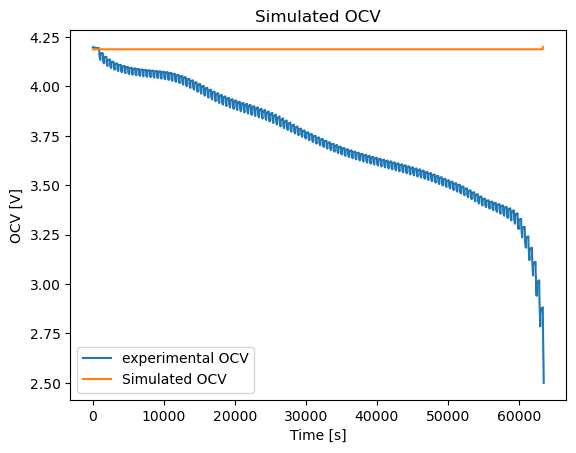

In [45]:

plt.plot(time_ex, voltage_ex, label='experimental OCV')
plt.plot(time, voltage, label='Simulated OCV')
plt.xlabel('Time [s]')
plt.ylabel('OCV [V]')
plt.title('Comparison of OCV-simulation and OCV-experiment-extract')
plt.legend()
plt.show()
